In [70]:
import pysam
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
import pylab

In [3]:
def keep_record(record):
    # We want to remove variants with uncertain locations
    return not ("CIEND" in record.info.keys() or "CIPOS" in record.info.keys())

In [4]:
vcf_path = "../to_tensor/data/estd219.GRCh37.variant_call.vcf.gz"
vcf = pysam.VariantFile(vcf_path, 'rb')

In [5]:
records = [record for record in vcf.fetch() if keep_record(record)]

In [85]:
sample_count = defaultdict(int)
type_count = defaultdict(int)
size_count = defaultdict(int)
chr_count = defaultdict(int)
region_count = defaultdict(int)
alt_count = defaultdict(int)

for record in records:
    sample_count[record.info["SAMPLE"]] += 1
    chr_count[record.chrom] += 1
    size_count[record.stop - record.start] += 1
    type_count[record.info["SVTYPE"]] += 1
    region_count[record.info["REGIONID"]] += 1
    alt_count[record.alts] += 1

In [46]:
chr_len = {
    "1" :  248956422,
    "2" :  242193529,
    "3" :  198295559,
    "4" :  190214555,
    "5" :  181538259,
    "6" :  170805979,
    "7" :  159345973,
    "8" :  145138636,
    "9" :  138394717,
    "10":  133797422,
    "11":  135086622,
    "12":  133275309,
    "13":  114364328,
    "14":  107043718,
    "15":  101991189,
    "16":  90338345 ,
    "17":  83257441 ,
    "18":  80373285 ,
    "19":  58617616 ,
    "20":  64444167 ,
    "21":  46709983 ,
    "22":  50818468 ,
    "X" :  156040895,
    "Y" :  57227415 ,
}

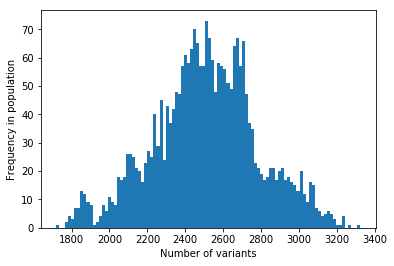

In [47]:
plt.hist(sample_count.values(), bins=100)
plt.xlabel("Number of variants")
plt.ylabel("Frequency in population")
plt.show()

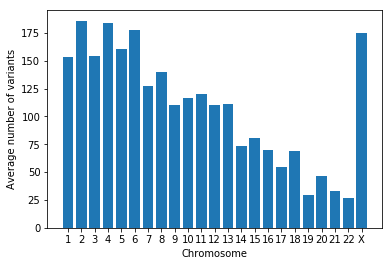

In [48]:
plt.bar(chr_count.keys(), np.array(list(chr_count.values()), dtype=np.float) / 2504)
plt.xlabel("Chromosome")
plt.ylabel("Average number of variants")
plt.show()

We can see that the amount of variant decreases as the size of the chromosomes decreases.

It is also odd to notice that no SV are found on the Y chromosome.

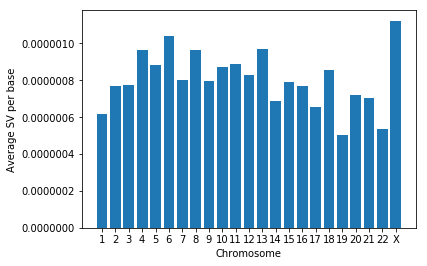

In [49]:
norm = defaultdict(float)
for x in chr_count.keys():
    norm[x] = chr_count[x] / chr_len[x] / 2504
    
plt.bar(norm.keys(), norm.values())
plt.xlabel("Chromosome")
plt.ylabel("Average SV per base")
plt.show()

The amount of variants per base is relatively uniform.

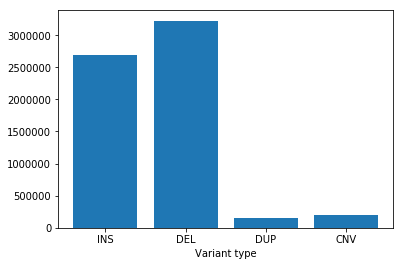

In [53]:
plt.bar(type_count.keys(), type_count.values())
plt.xlabel("Variant type")
plt.ylabel("Number of variants")
plt.show()

This graph compared to the next one shows that the SVTYPE field is troubling not precise enough for us

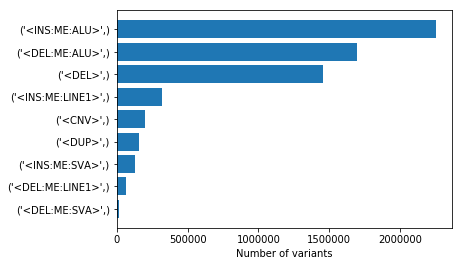

In [94]:
alts = [(str(alt), count) for (alt, count) in alt_count.items()]
sorted_alts = sorted(alts, key=lambda alt: alt[1])
pos = pylab.arange(len(sorted_alts))+.5
plt.barh(pos, [alt[1] for alt in sorted_alts])
plt.xlabel("Number of variants")
plt.yticks(pos, [alt[0] for alt in sorted_alts])
plt.show()

This graph shows that a vast majority of the VCF records are related to mobile elements.  
Our algorithm should be working for the deletions (their size needs to be analyzed however).

It is also noteworthy that the amount of `INS:ME:$TYPE` does not match the amount of `DEL:ME:$TYPE`.

In [15]:
sizes = np.array(list(size_count.values()))
print(sizes.mean())
print(len(sizes))
percentiles = [1, 10, 20, 50, 80, 90, 99, 99.9]
print(np.percentile(sizes, percentiles))

637.0102371781877
9866
[1.0000000e+00 1.0000000e+00 1.0000000e+00 2.0000000e+00 1.0000000e+01
 7.5000000e+01 7.9268500e+03 5.1285585e+04]


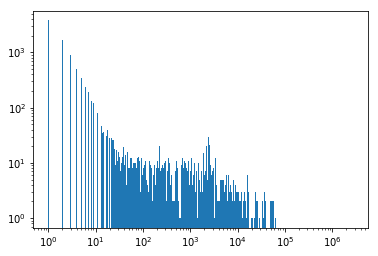

In [22]:
bins = bins=np.logspace(np.log10(sizes.min()),np.log10(sizes.max()), 400)
plt.hist(sizes, bins=bins)
plt.loglog()
plt.show()

This distribution shows a good concentration of the data between $10^2$ bases and $10^4$ bases.  
It is interesting to note that our data transformation does not reduce the dimension for variants smaller than $10^3$ bp as it shows all the reads there.

When investigating the performances it might be interesting to see if we observe a drastic change in acuray when we have to "split" the window.

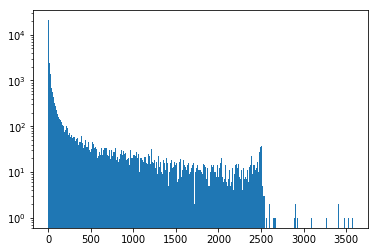

In [37]:
plt.hist(region_count.values(), bins=400)
plt.semilogy()
plt.show()